In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve

import matplotlib.colors as colors
import matplotlib.cm as cmx

# Speed scaling $V_{drive}$

In [2]:

def bar(t, xc, b = 0.160, v = 1):

    if xc >=-b+v*t and xc <=b+v*t :
        return 1
    else: 
        return 0
    

In [3]:
def biphasic_alpha(t,tauOPL,tauOPL2,SF):
    
    kern =  (t/tauOPL**2) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2**2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = (t/tauOPL) * np.exp(-t/tauOPL) * np.heaviside(t,1) -  SF* (t/tauOPL2) * np.exp(-t/tauOPL2) * np.heaviside(t,1) 
    # kern = kern/(np.sum(kern)*0.001)
    #calculate integral
    return  kern


tauOPLmono = 0.04
tauOPL = 0.08
tauOPL2 = 0.0876
SF = 1.

ftime = np.arange(0,1,0.001)
filter_mono = biphasic_alpha(ftime,tauOPLmono,1,0)
filter_mono = filter_mono/filter_mono.max()
filter_bi = biphasic_alpha(ftime,tauOPL,tauOPL2,SF)
filter_bi = filter_bi/filter_bi.max()


In [4]:
speeds = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0])

In [5]:
data = {}
cell = 150
# nets_list = ['Reciporcal_fitted/wBA/wBA_31.0',
#              'Reciporcal_fitted/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_mono_linear/wBA/wBA_31.0',
#              'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_0.0',
#              'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_0.0',]
nets_list = ['Reciporcal_fitted/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_0.0',
             'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_0.0',
             'Reciporcal_fitted/noGCGainControl/wBA/wBA_0.0']

for net in nets_list:
    
    data[net] = {}

    bars = []
    tps_rf_GC_mid = []
    times = []

    Fs = []
    inps = []
    RBs = []
    RAs = []
    RGs = []

    peaks_RG = []
    peaks_RB = []
    peaks_drive = []

    amps_RB = []
    amps_RA = []
    amps_RG = []
    amps_drive = []
    amps_inp = []

    ants_RB_drive = []
    ants_RB_bar = []

    ants_RG_drive = []
    ants_RG_bar = []
    ants_drive = []

    for s in speeds: 
        fp = f'/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/{net}/smooth_{s}'
        with open(f'{fp}/out', 'rb') as handle:
            out = pickle.load(handle)    
            
        with open(f'{fp}/params', 'rb') as handle:
            paramsi = pickle.load(handle)
            
        duration = paramsi['duration']
        dt = paramsi['dt']
        time = np.arange(0,duration,dt) #- (paramsi['spacing']*cell)/paramsi['speed']#*1000#+45
        pos_cell = paramsi['pos_rf_GC_mid'][cell]
        barr = [bar(t,pos_cell, v = s) for t in time]
        tp_bar = paramsi['tps_rf_GC_mid'][cell]

        peak_RB = time[np.argmax(out['RB'][50,:])]
        peak_RG = time[np.argmax(out['RG'][:])]
        peak_drive = time[np.argmax(out['F'][:])]

        amp_RB = np.max(out['RB'][50,:])
        amp_RA = np.max(out['RA'][50,:])
        amp_RG = np.max(out['RG'][:])
        amp_drive = np.max(out['F'][:])
        amp_inp = np.max(out['inp'][:])

        


        # RAM
        ant_RB_drive =  peak_drive - peak_RB
        ant_RB_bar  =  tp_bar - peak_RB

        ant_RG_drive =  peak_drive - peak_RG
        ant_RG_bar =  tp_bar - peak_RG
    
        ant_drive =  tp_bar - peak_drive

        bars.append(barr)
        tps_rf_GC_mid.append(tp_bar)
        times.append(time)

        Fs.append(out['F'])
        inps.append(out['inp'])
        RBs.append(out['RB'][50,:])
        RAs.append(out['RA'][50,:])
        RGs.append(out['RG'])

        peaks_RB.append(peak_RB)
        peaks_RG.append(peak_RG)
        peaks_drive.append(peak_drive)

        amps_RB.append(amp_RB)
        amps_RA.append(amp_RA)
        amps_RG.append(amp_RG)
        amps_drive.append(amp_drive)
        amps_inp.append(amp_inp)

        ants_RB_drive.append(ant_RB_drive)
        ants_RB_bar.append(ant_RB_bar)
        
        ants_RG_drive.append(ant_RG_drive)
        ants_RG_bar.append(ant_RG_bar)
        ants_drive.append(ant_drive)


    
    data[net]['peaks']={}
    data[net]['peaks']['RB'] = np.asarray(peaks_RB)
    data[net]['peaks']['RG'] = np.asarray(peaks_RG)
    data[net]['peaks']['drive'] =np.asarray( peaks_drive)  

    data[net]['amps']={}
    data[net]['amps']['RB'] = np.asarray(amps_RB)
    data[net]['amps']['RA'] = np.asarray(amps_RA)
    data[net]['amps']['RG'] = np.asarray(amps_RG)
    data[net]['amps']['drive'] =np.asarray( amps_drive)
    data[net]['amps']['inp'] =np.asarray( amps_inp)

    data[net]['ants'] ={}
    data[net]['ants']['RB_drive'] =np.asarray(ants_RB_drive)
    data[net]['ants']['RB_bar'] =np.asarray(ants_RB_bar)
    data[net]['ants']['RG_drive'] =np.asarray(ants_RG_drive)
    data[net]['ants']['RG_bar'] =np.asarray(ants_RG_bar)
    data[net]['ants']['drive'] =np.asarray(ants_drive)
    
    data[net]['RB'] = RBs
    data[net]['RA'] = RAs
    data[net]['RG'] = RGs
    data[net]['F'] = Fs


    data[net]['input_scale'] = paramsi['input_scale']

    data['bars'] = bars
    data['tps_rf_mid'] = np.asarray(tps_rf_GC_mid)
    data['times'] = times


FileNotFoundError: [Errno 2] No such file or directory: '/user/sebert/home/Documents/Simulations/motion/anticipation_1D/Reciporcal/Reciporcal_fitted/noGCGainControl/wBA/wBA_31.0/smooth_0.1/out'

In [24]:
out.keys()

dict_keys(['res', 'VB', 'OB', 'AB', 'NB', 'GB', 'RB', 'VA', 'OA', 'AA', 'NA', 'GA', 'RA', 'VG', 'AG', 'GG', 'NG', 'RG', 'PVA', 'inp', 'F'])

No handles with labels found to put in legend.


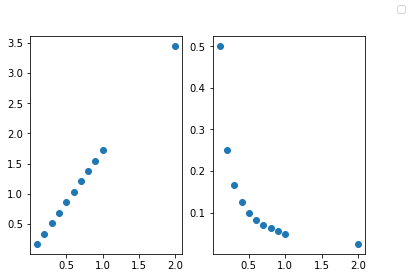

In [6]:
# calculate rho 
def taucross(v,sigma):
    return sigma/v

def rho(tau,taucross):
    return tau/taucross

tau = paramsi['tauOPL']
sigma = paramsi['rf_BC']/6

tcrosses = [taucross(vi,sigma) for vi in speeds]
rohs = [rho(tau,ti) for ti in tcrosses]

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.scatter(speeds,rohs)

ax = fig.add_subplot(1,2,2)

ax.scatter(speeds,tcrosses)
# for x in taunBs:
#     plt.axhline(x)

fig.legend()

In [7]:
def normalize(vals):
    vals = np.asarray(vals)
    return (vals-np.mean(vals))/np.std(vals)


In [8]:
net_mono = nets_list[2]
net_bi = nets_list[1]

In [9]:
speeds_plot = [0.1,0.5,1.0]
speeds_plot_idx = [0,4,-2]
xlims = [(2,12),(1.2,3),(0.2,0.75)]

# Figure Parameter

In [10]:
fontsize_legend = 15
fontsize_labels = 15
fontsize_panellabel = 30
fontsize_ticks = 10
lw = 4
ms = 60

figsize_ratio = 3
figsize = (22,12)

save = True
save_name = "Figure 1"
show = True
image_format = "png"
dpi = 300

panellabel_position = [-0.17, .8]



In [11]:
%matplotlib inline

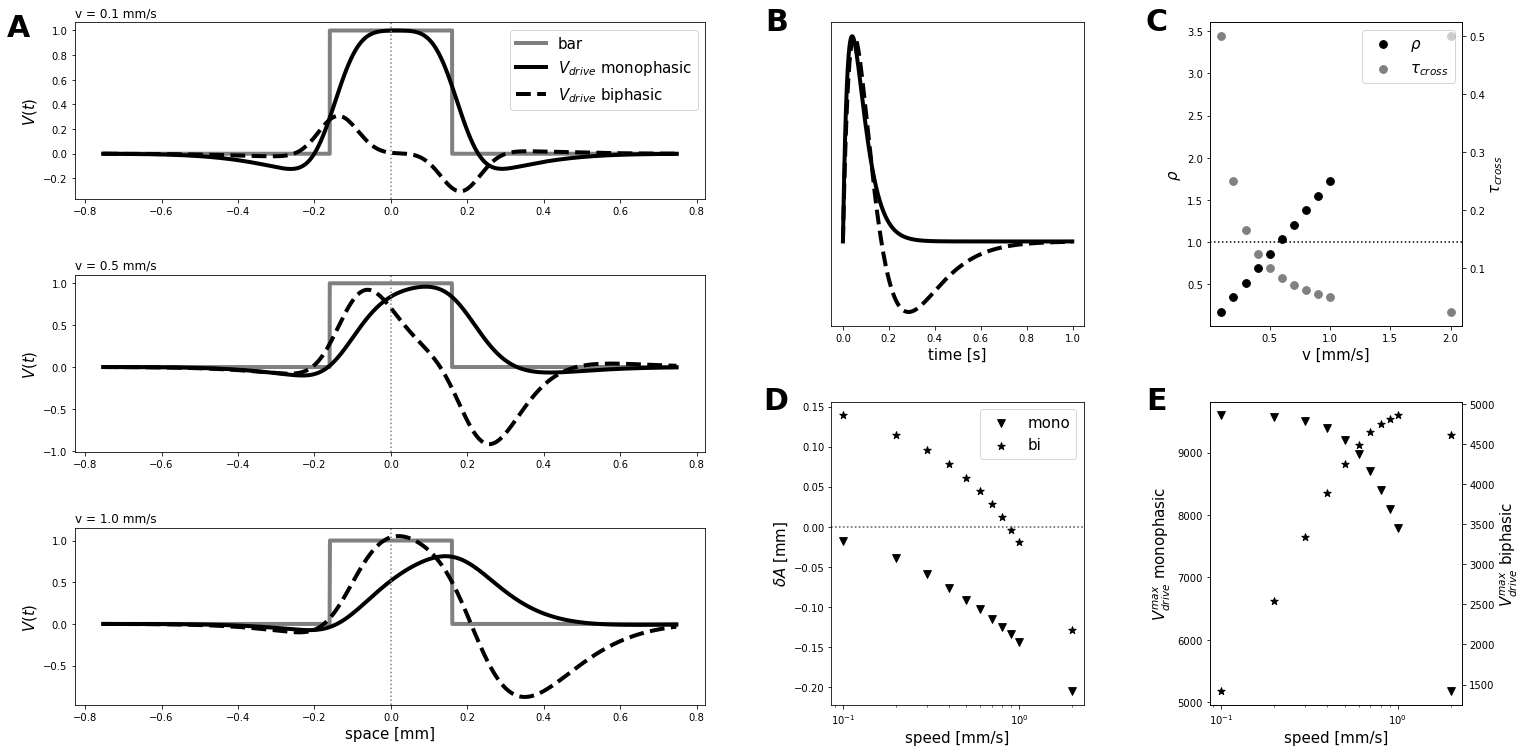

In [12]:


#initialize figure
nrows = 6
ncols = 4

fig = plt.figure(figsize=figsize)
#fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)
#fig.tight_layout()



fig.subplots_adjust(top=0.892,
                        bottom=0.102,
                        left=0.068,
                        right=0.944,
                        hspace=1.5,
                        wspace=.5)
cbar = 'grey'
c1 = 'k'

net = nets_list[0]
net_mono = nets_list[2]


#TODO remove axis 

#TODO change fontsizes etc

for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[2*x:2*x+2,:2])


        ax.text(panellabel_position[0]+0.1,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
    else:
        ax = fig.add_subplot(gs[2*x:2*x+2,:2], sharex = ax)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    xdata =(data['times'][i]- data['tps_rf_mid'][i])*s 
    ax.plot(xdata,data['bars'][i], label = f'bar', color = cbar, linewidth = lw)

    # plot drive 
    # ax.plot(xdata,data[net_mono]['F'][i]/np.max(data[net_mono]['F'][0]), label = '$V_{drive}$ monophasic', color = c1)
    # ax.plot(xdata,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$ biphasic', color = c1, linestyle = '--')
    ax.plot(xdata,data[net_mono]['F'][i]/np.max(data[net_mono]['F'][0]), label = '$V_{drive}$ monophasic', color = c1, linewidth = lw)
    ax.plot(xdata,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$ biphasic', color = c1, linestyle = '--', linewidth = lw)

    ax.axvline(0, color = cbar, linestyle = ':')
    # # plot RB
    # ax2.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'blue')
    # ax2.plot(data['times'][i]*s,data[net_pool]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB without lateral connectivity', color = 'blue', linestyle = ':')
    # ax2.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')

    # plot RG
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if x ==0 :
        ax.legend(fontsize = fontsize_legend, loc = 'upper right')

    ax.set_ylabel('$V(t)$', fontsize = fontsize_labels)
    if x == 2:
        ax.set_xlabel('space [mm]', fontsize = fontsize_labels)

    ax.tick_params(labelsize = fontsize_ticks)
#fig.suptitle(f'{net}')


fil = fig.add_subplot(gs[0:3,2])


fil.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=fil.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
fil.plot(ftime,filter_mono, color =c1, linestyle = '-', linewidth = lw)
fil.plot(ftime,filter_bi, color =c1, linestyle = '--', linewidth = lw)
fil.set_xlabel('time [s]', fontsize = fontsize_labels)
fil.set_yticks([])
fil.tick_params(labelsize = fontsize_ticks)


rh = fig.add_subplot(gs[0:3,3])


rh.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=rh.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
rh.scatter(speeds,rohs, color = c1, label = r'$\rho$', s = ms)

rh2= rh.twinx()
rh2.scatter(speeds,tcrosses, color = cbar, label = r'$\tau_{cross}$', s = ms)

rh.axhline(1, color = 'k', linestyle = ':')
#rh.axvline(.6, color = 'k', linestyle = ':')
rh.set_xlabel('v [mm/s]', fontsize = fontsize_labels)
rh.set_ylabel(r'$\rho$', fontsize = fontsize_labels)
rh2.set_ylabel(r'$\tau_{cross}$', fontsize = fontsize_labels)

lines, labels = rh.get_legend_handles_labels()
lines2, labels2 = rh2.get_legend_handles_labels()
rh2.legend(lines + lines2, labels + labels2, loc=0, fontsize = fontsize_legend)
rh.tick_params(labelsize = fontsize_ticks)
rh2.tick_params(labelsize = fontsize_ticks)



amp = fig.add_subplot(gs[3:,3])  



amp.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "E", transform=amp.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


amp.scatter(speeds, data[net_mono]['amps']['drive'],marker= 'v',  color = c1, label = 'monophasic', s = ms)

amp2 = amp.twinx()
amp2.scatter(speeds, data[net]['amps']['drive'],marker= '*',  color = c1, label = 'biphaic', s = ms)
#amp2.axvline(.6, color = 'k', linestyle = ':')

amp.set_xscale('log')
amp.set_xlabel('speed [mm/s]', fontsize = fontsize_labels)
amp.set_ylabel('$V^{max}_{drive}$ monophasic' , fontsize = fontsize_labels)
amp2.set_ylabel('$V^{max}_{drive}$ biphasic' , fontsize = fontsize_labels)
amp.tick_params(labelsize = fontsize_ticks)
amp2.tick_params(labelsize = fontsize_ticks)

# lines, labels = amp.get_legend_handles_labels()
# lines2, labels2 = amp2.get_legend_handles_labels()
# amp2.legend(lines + lines2, labels + labels2, loc=0)


an = fig.add_subplot(gs[3:,2])  


an.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "D", transform=an.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
an.scatter(speeds, data[net_mono]['ants']['drive']*speeds,marker= 'v',  color = c1, label = 'mono',s = ms)
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= '*',  color = c1, label = 'bi', s = ms)
an.axhline(0, color = cbar, linestyle = ':')

#an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'blue')
# an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'green')
# an.scatter(speeds, data[net_mono]['ants']['RG_bar']*speeds, color = 'orange')
#an.axvline(.6, color = 'k', linestyle = ':')
an.axhline(0, color = cbar, linestyle = ':')
an.set_xscale('log')
an.set_xlabel('speed [mm/s]', fontsize = fontsize_labels)
an.set_ylabel('$\delta A$ [mm]', fontsize = fontsize_labels)
an.legend(fontsize = fontsize_legend)
an.tick_params(labelsize = fontsize_ticks)


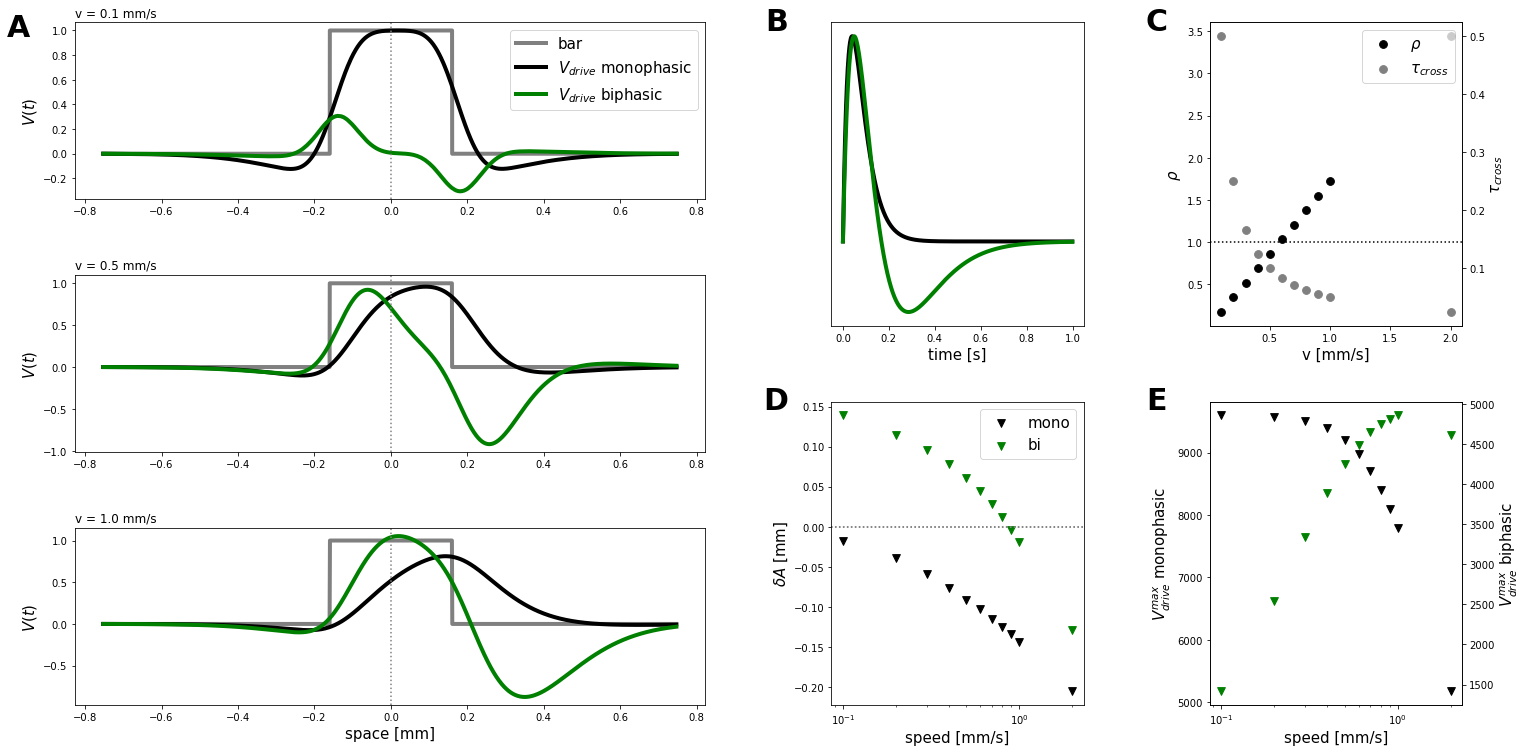

In [13]:


#initialize figure
nrows = 6
ncols = 4

fig = plt.figure(figsize=figsize)
#fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)
#fig.tight_layout()



fig.subplots_adjust(top=0.892,
                        bottom=0.102,
                        left=0.068,
                        right=0.944,
                        hspace=1.5,
                        wspace=.5)
cbar = 'grey'
c1 = 'k'
c2 = 'green'
net = nets_list[0]
net_mono = nets_list[2]


#TODO remove axis 

#TODO change fontsizes etc

for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[2*x:2*x+2,:2])


        ax.text(panellabel_position[0]+0.1,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
    else:
        ax = fig.add_subplot(gs[2*x:2*x+2,:2], sharex = ax)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    xdata =(data['times'][i]- data['tps_rf_mid'][i])*s 
    ax.plot(xdata,data['bars'][i], label = f'bar', color = cbar, linewidth = lw)

    # plot drive 
    # ax.plot(xdata,data[net_mono]['F'][i]/np.max(data[net_mono]['F'][0]), label = '$V_{drive}$ monophasic', color = c1)
    # ax.plot(xdata,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$ biphasic', color = c1, linestyle = '--')
    ax.plot(xdata,data[net_mono]['F'][i]/np.max(data[net_mono]['F'][0]), label = '$V_{drive}$ monophasic', color = c1, linewidth = lw)
    ax.plot(xdata,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$ biphasic', color = c2, linestyle = '-', linewidth = lw)

    ax.axvline(0, color = cbar, linestyle = ':')
    # # plot RB
    # ax2.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'blue')
    # ax2.plot(data['times'][i]*s,data[net_pool]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB without lateral connectivity', color = 'blue', linestyle = ':')
    # ax2.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')

    # plot RG
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if x ==0 :
        ax.legend(fontsize = fontsize_legend, loc = 'upper right')

    ax.set_ylabel('$V(t)$', fontsize = fontsize_labels)
    if x == 2:
        ax.set_xlabel('space [mm]', fontsize = fontsize_labels)

    ax.tick_params(labelsize = fontsize_ticks)
#fig.suptitle(f'{net}')




fil = fig.add_subplot(gs[:3,2])


fil.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=fil.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
fil.plot(ftime,filter_mono, color =c1, linestyle = '-', linewidth = lw)
fil.plot(ftime,filter_bi, color =c2, linestyle = '-', linewidth = lw)
fil.set_xlabel('time [s]', fontsize = fontsize_labels)
fil.set_yticks([])
fil.tick_params(labelsize = fontsize_ticks)


rh = fig.add_subplot(gs[:3,3])


rh.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=rh.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
rh.scatter(speeds,rohs, color = c1, label = r'$\rho$', s = ms)

rh2= rh.twinx()
rh2.scatter(speeds,tcrosses, color = cbar, label = r'$\tau_{cross}$', s = ms)

rh.axhline(1, color = 'k', linestyle = ':')
#rh.axvline(.6, color = 'k', linestyle = ':')
rh.set_xlabel('v [mm/s]', fontsize = fontsize_labels)
rh.set_ylabel(r'$\rho$', fontsize = fontsize_labels)
rh2.set_ylabel(r'$\tau_{cross}$', fontsize = fontsize_labels)

lines, labels = rh.get_legend_handles_labels()
lines2, labels2 = rh2.get_legend_handles_labels()
rh2.legend(lines + lines2, labels + labels2, loc=0, fontsize = fontsize_legend)
rh.tick_params(labelsize = fontsize_ticks)
rh2.tick_params(labelsize = fontsize_ticks)



amp = fig.add_subplot(gs[3:,3])  



amp.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "E", transform=amp.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


amp.scatter(speeds, data[net_mono]['amps']['drive'],marker= 'v',  color = c1, label = 'monophasic', s = ms)

amp2 = amp.twinx()
amp2.scatter(speeds, data[net]['amps']['drive'],marker= 'v',  color = c2, label = 'biphaic', s = ms)
#amp2.axvline(.6, color = 'k', linestyle = ':')

amp.set_xscale('log')
amp.set_xlabel('speed [mm/s]', fontsize = fontsize_labels)
amp.set_ylabel('$V^{max}_{drive}$ monophasic' , fontsize = fontsize_labels)
amp2.set_ylabel('$V^{max}_{drive}$ biphasic' , fontsize = fontsize_labels)
amp.tick_params(labelsize = fontsize_ticks)
amp2.tick_params(labelsize = fontsize_ticks)

# lines, labels = amp.get_legend_handles_labels()
# lines2, labels2 = amp2.get_legend_handles_labels()
# amp2.legend(lines + lines2, labels + labels2, loc=0)


an = fig.add_subplot(gs[3:,2])  


an.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "D", transform=an.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
an.scatter(speeds, data[net_mono]['ants']['drive']*speeds,marker= 'v',  color = c1, label = 'mono',s = ms)
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= 'v',  color = c2, label = 'bi', s = ms)
an.axhline(0, color = cbar, linestyle = ':')

#an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'blue')
# an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'green')
# an.scatter(speeds, data[net_mono]['ants']['RG_bar']*speeds, color = 'orange')
#an.axvline(.6, color = 'k', linestyle = ':')
an.axhline(0, color = cbar, linestyle = ':')
an.set_xscale('log')
an.set_xlabel('speed [mm/s]', fontsize = fontsize_labels)
an.set_ylabel('$\delta A$ [mm]', fontsize = fontsize_labels)
an.legend(fontsize = fontsize_legend)
an.tick_params(labelsize = fontsize_ticks)


In [14]:
#%matplotlib qt

In [19]:
figsize = (12,20)


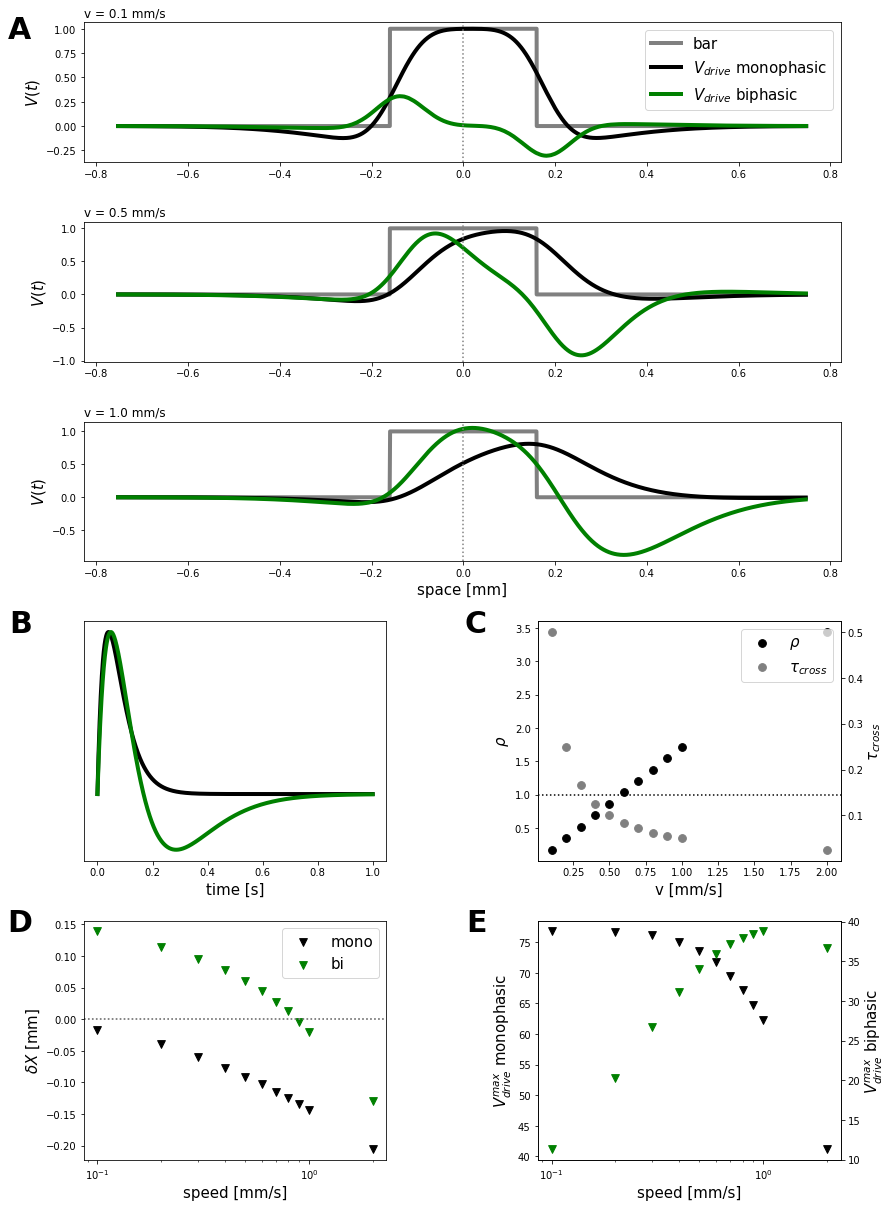

In [30]:


#initialize figure
nrows = 12
ncols = 2

fig = plt.figure(figsize=figsize)
#fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)
#fig.tight_layout()



fig.subplots_adjust(top=0.892,
                        bottom=0.102,
                        left=0.068,
                        right=0.944,
                        hspace=1.5,
                        wspace=.5)
cbar = 'grey'
c1 = 'k'
c2 = 'green'
net = nets_list[0]
net_mono = nets_list[2]


#TODO remove axis 

#TODO change fontsizes etc

for x,s in enumerate(speeds_plot):
    i = speeds_plot_idx[x]
    #title
    if i == 0:
        ax = fig.add_subplot(gs[2*x:2*x+2,:])


        ax.text(panellabel_position[0]+0.1,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
    else:
        ax = fig.add_subplot(gs[2*x:2*x+2,:], sharex = ax)
      
    ax.set_title(f'v = {s} mm/s', loc = 'left')
    # plot bar
    xdata =(data['times'][i]- data['tps_rf_mid'][i])*s 
    ax.plot(xdata,data['bars'][i], label = f'bar', color = cbar, linewidth = lw)

    # plot drive 
    # ax.plot(xdata,data[net_mono]['F'][i]/np.max(data[net_mono]['F'][0]), label = '$V_{drive}$ monophasic', color = c1)
    # ax.plot(xdata,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$ biphasic', color = c1, linestyle = '--')
    ax.plot(xdata,data[net_mono]['F'][i]/np.max(data[net_mono]['F'][0]), label = '$V_{drive}$ monophasic', color = c1, linewidth = lw)
    ax.plot(xdata,data[net]['F'][i]/np.max(data[net]['F'][-1]), label = '$V_{drive}$ biphasic', color = c2, linestyle = '-', linewidth = lw)

    ax.axvline(0, color = cbar, linestyle = ':')
    # # plot RB
    # ax2.plot(data['times'][i]*s,data[net]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB', color = 'blue')
    # ax2.plot(data['times'][i]*s,data[net_pool]['RB'][i]/np.max(data[net]['RB'][-1]), label = f'RB without lateral connectivity', color = 'blue', linestyle = ':')
    # ax2.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')

    # plot RG
    #ax.plot(data['times'][i]*s,data[net]['RA'][i]/np.max(data[net]['RA'][-1]), label = f'RA', color = 'red')
    if x ==0 :
        ax.legend(fontsize = fontsize_legend, loc = 'upper right')

    ax.set_ylabel('$V(t)$', fontsize = fontsize_labels)
    if x == 2:
        ax.set_xlabel('space [mm]', fontsize = fontsize_labels)

    ax.tick_params(labelsize = fontsize_ticks)
#fig.suptitle(f'{net}')




fil = fig.add_subplot(gs[6:9,0])


fil.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=fil.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
fil.plot(ftime,filter_mono, color =c1, linestyle = '-', linewidth = lw)
fil.plot(ftime,filter_bi, color =c2, linestyle = '-', linewidth = lw)
fil.set_xlabel('time [s]', fontsize = fontsize_labels)
fil.set_yticks([])
fil.tick_params(labelsize = fontsize_ticks)


rh = fig.add_subplot(gs[6:9,1])


rh.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=rh.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
rh.scatter(speeds,rohs, color = c1, label = r'$\rho$', s = ms)

rh2= rh.twinx()
rh2.scatter(speeds,tcrosses, color = cbar, label = r'$\tau_{cross}$', s = ms)

rh.axhline(1, color = 'k', linestyle = ':')
#rh.axvline(.6, color = 'k', linestyle = ':')
rh.set_xlabel('v [mm/s]', fontsize = fontsize_labels)
rh.set_ylabel(r'$\rho$', fontsize = fontsize_labels)
rh2.set_ylabel(r'$\tau_{cross}$', fontsize = fontsize_labels)

lines, labels = rh.get_legend_handles_labels()
lines2, labels2 = rh2.get_legend_handles_labels()
rh2.legend(lines + lines2, labels + labels2, loc=0, fontsize = fontsize_legend)
rh.tick_params(labelsize = fontsize_ticks)
rh2.tick_params(labelsize = fontsize_ticks)



amp = fig.add_subplot(gs[9:,1])  



amp.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "E", transform=amp.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


amp.scatter(speeds, data[net_mono]['amps']['inp'],marker= 'v',  color = c1, label = 'monophasic', s = ms)

amp2 = amp.twinx()
amp2.scatter(speeds, data[net]['amps']['inp'],marker= 'v',  color = c2, label = 'biphaic', s = ms)
#amp2.axvline(.6, color = 'k', linestyle = ':')

amp.set_xscale('log')
amp.set_xlabel('speed [mm/s]', fontsize = fontsize_labels)
amp.set_ylabel('$V^{max}_{drive}$ monophasic' , fontsize = fontsize_labels)
amp2.set_ylabel('$V^{max}_{drive}$ biphasic' , fontsize = fontsize_labels)
amp.tick_params(labelsize = fontsize_ticks)
amp2.tick_params(labelsize = fontsize_ticks)

# lines, labels = amp.get_legend_handles_labels()
# lines2, labels2 = amp2.get_legend_handles_labels()
# amp2.legend(lines + lines2, labels + labels2, loc=0)


an = fig.add_subplot(gs[9:,0])  


an.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "D", transform=an.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')
an.scatter(speeds, data[net_mono]['ants']['drive']*speeds,marker= 'v',  color = c1, label = 'mono',s = ms)
an.scatter(speeds, data[net]['ants']['drive']*speeds,marker= 'v',  color = c2, label = 'bi', s = ms)
an.axhline(0, color = cbar, linestyle = ':')

#an.scatter(speeds, data[net]['ants']['RB_bar']*speeds, color = 'blue')
# an.scatter(speeds, data[net]['ants']['RG_bar']*speeds, color = 'green')
# an.scatter(speeds, data[net_mono]['ants']['RG_bar']*speeds, color = 'orange')
#an.axvline(.6, color = 'k', linestyle = ':')
an.axhline(0, color = cbar, linestyle = ':')
an.set_xscale('log')
an.set_xlabel('speed [mm/s]', fontsize = fontsize_labels)
an.set_ylabel('$\delta X$ [mm]', fontsize = fontsize_labels)
an.legend(fontsize = fontsize_legend)
an.tick_params(labelsize = fontsize_ticks)


In [28]:
data[net_mono]['amps']['inp']

array([76.78360701, 76.6259654 , 76.12331601, 75.12777569, 73.64392939,
       71.75328267, 69.56389924, 67.1895849 , 64.70283769, 62.24663821,
       41.17195153])